In [2]:
%pip install deepxde

  Using cached DeepXDE-1.11.1-py3-none-any.whl.metadata (12 kB)
  Using cached scikit_optimize-0.10.2-py2.py3-none-any.whl.metadata (9.7 kB)
  Using cached pyaml-24.4.0-py3-none-any.whl.metadata (11 kB)
Using cached DeepXDE-1.11.1-py3-none-any.whl (182 kB)
Using cached scikit_optimize-0.10.2-py2.py3-none-any.whl (107 kB)
Using cached pyaml-24.4.0-py3-none-any.whl (24 kB)
Note: you may need to restart the kernel to use updated packages.


No backend selected.
Finding available backend...


Using backend: pytorch
Other supported backends: tensorflow.compat.v1, tensorflow, jax, paddle.
paddle supports more examples now and is recommended.


Found pytorch
Setting the default backend to "pytorch". You can change it in the ~/.deepxde/config.json file or export the DDE_BACKEND environment variable. Valid options are: tensorflow.compat.v1, tensorflow, pytorch, jax, paddle (all lowercase)
Compiling model...
'compile' took 4.932483 s

Training model...

Step      Train loss                        Test loss                         Test metric   
0         [1.55e+01, 1.49e-02, 4.97e-01]    [1.65e+01, 1.49e-02, 4.97e-01]    [1.01e+00]    
1000      [2.44e-03, 3.56e-03, 5.75e-04]    [4.46e-03, 3.56e-03, 5.75e-04]    [7.22e-02]    
2000      [6.46e-04, 7.02e-04, 2.14e-04]    [1.17e-03, 7.02e-04, 2.14e-04]    [3.23e-02]    
3000      [2.37e-04, 4.68e-05, 2.48e-05]    [4.76e-04, 4.68e-05, 2.48e-05]    [8.58e-03]    
4000      [1.11e-04, 5.65e-06, 7.35e-06]    [3.12e-04, 5.65e-06, 7.35e-06]    [3.45e-03]    
5000      [6.38e-05, 3.22e-06, 4.39e-06]    [2.49e-04, 3.22e-06, 4.39e-06]    [2.64e-03]    
6000      [2.51e-04, 6.10e-06, 4.27e-

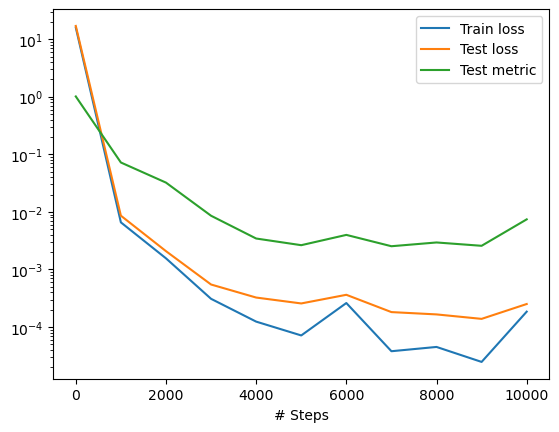

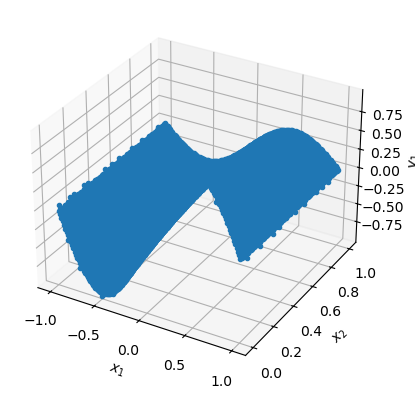

In [3]:
"""Backend supported: tensorflow.compat.v1, tensorflow, pytorch, jax, paddle"""
import deepxde as dde
import numpy as np
# Backend tensorflow.compat.v1 or tensorflow
from deepxde.backend import torch
# Backend pytorch
# import torch
# Backend jax
# import jax.numpy as jnp
# Backend paddle
# import paddle


def pde(x, y):
    # Most backends
    dy_t = dde.grad.jacobian(y, x, j=1)
    dy_xx = dde.grad.hessian(y, x, j=0)
    # Backend jax
    # dy_t, _ = dde.grad.jacobian(y, x, j=1)
    # dy_xx, _ = dde.grad.hessian(y, x, j=0)
    # Backend tensorflow.compat.v1 or tensorflow
    # return (
    #     dy_t
    #     - dy_xx
    #     + tf.exp(-x[:, 1:])
    #     * (tf.sin(np.pi * x[:, 0:1]) - np.pi ** 2 * tf.sin(np.pi * x[:, 0:1]))
    # )
    # Backend pytorch
    return (
        dy_t
        - dy_xx
        + torch.exp(-x[:, 1:])
        * (torch.sin(np.pi * x[:, 0:1]) - np.pi ** 2 * torch.sin(np.pi * x[:, 0:1]))
    )
    # Backend jax
    # return (
    #     dy_t
    #     - dy_xx
    #     + jnp.exp(-x[:, 1:])
    #     * (jnp.sin(np.pi * x[..., 0:1]) - np.pi ** 2 * jnp.sin(np.pi * x[..., 0:1]))
    # )
    # Backend paddle
    # return (
    #     dy_t
    #     - dy_xx
    #     + paddle.exp(-x[:, 1:])
    #     * (paddle.sin(np.pi * x[:, 0:1]) - np.pi ** 2 * paddle.sin(np.pi * x[:, 0:1]))
    # )


def func(x):
    return np.sin(np.pi * x[:, 0:1]) * np.exp(-x[:, 1:])


geom = dde.geometry.Interval(-1, 1)
timedomain = dde.geometry.TimeDomain(0, 1)
geomtime = dde.geometry.GeometryXTime(geom, timedomain)

bc = dde.icbc.DirichletBC(geomtime, func, lambda _, on_boundary: on_boundary)
ic = dde.icbc.IC(geomtime, func, lambda _, on_initial: on_initial)
data = dde.data.TimePDE(
    geomtime,
    pde,
    [bc, ic],
    num_domain=40,
    num_boundary=20,
    num_initial=10,
    solution=func,
    num_test=10000,
)

layer_size = [2] + [32] * 3 + [1]
activation = "tanh"
initializer = "Glorot uniform"
net = dde.nn.FNN(layer_size, activation, initializer)

model = dde.Model(data, net)

model.compile("adam", lr=0.001, metrics=["l2 relative error"])
losshistory, train_state = model.train(iterations=10000)

dde.saveplot(losshistory, train_state, issave=True, isplot=True)

In [ ]:
import matplotlib as plt

In [ ]:
# Create a grid of x and t values
x_values = torch.linspace(-1, 1, 100)
t_values = torch.linspace(0, 1, 100)
x_grid, t_grid = torch.meshgrid(x_values, t_values, indexing='ij')

# Compute the diffusion values on the grid
with torch.no_grad():
    u_values = model()

# Convert to numpy for plotting
x_grid_np = x_grid.numpy()
t_grid_np = t_grid.numpy()
u_values_np = u_values.numpy()

# Plotting the 2D colored graph
plt.figure(figsize=(10, 6))
plt.pcolormesh(t_grid_np, x_grid_np, u_values_np, shading='auto', cmap='inferno')
plt.colorbar(label='u(x,t)')
plt.xlabel('Time (t)')
plt.ylabel('Position (x)')
plt.title('Our model solution')
plt.show()